# Recurrent Neural Network

![](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41598-024-58334-x/MediaObjects/41598_2024_58334_Fig1_HTML.png)
(ตัวอย่างใกล้เกคียง)

เขียน Simple NER tagger ด้วย BiLSTM pytorch เเละเปรียบเทียบผล accuracy และ chunk-level F1

0. Download Data: ดาวน์โหลดชุดข้อมูล OntoNotes NER และ GloVe embeddings

1. Load and Prepare Data: อ่านข้อมูลดิบ โดยแยกคำ และแท็ก (label) ออกเป็นรายการประโยค

2. Build Vocabularies and Mappings: สร้าง Vocabulary การจับคู่คำ/แท็กกับดัชนี และโหลด pre-trained GloVe embeddings ลงใน matrix

3. Vectorize and Pad Sequences: แปลงลำดับคำ/แท็กเป็นดัชนี

4. เติม (pad) ให้มีความยาวสูงสุดเท่ากันทั้งหมด

5. Train/Dev Split: แบ่งข้อมูลตัวเลขที่เติมแล้วและประโยคต้นฉบับ ออกเป็นชุดสำหรับ Train และ Dev (Development)

6. Create DataLoader: สร้าง PyTorch DataLoaders เพื่อจัดการแบ่งข้อมูล Train/Dev เป็นชุดย่อย (batch)

7. Define the Simplified BiLSTM Model: กำหนดโครงสร้างโมเดล BiLSTM โดยใช้ nn.Module ของ PyTorch

8. Initialize Model, Optimizer, Loss: สร้างโมเดล BiLSTM, Adam optimizer, และฟังก์ชัน CrossEntropy Loss (โดยไม่คิดค่า padding)

9. Training Loop: ฝึกโมเดลหลายรอบ (epoch) โดยคำนวณ loss, ปรับปรุงน้ำหนัก, และประเมิน token accuracy บนชุด Dev

    * Plotting: พล็อตกราฟแสดงค่า Loss (Train/Validation) และ Validation Token Accuracy โดยใช้ matplotlib

10. Final Evaluation: ประเมินผลโมเดลสุดท้ายบนชุด Dev โดยใช้ seqeval เพื่อดูค่าชี้วัดโดยละเอียด (accuracy, F1, report)

11. Test on Custom Sentence: เตรียมข้อมูลประโยคใหม่ ทำนายแท็ก NER ด้วยโมเดลที่ฝึกแล้ว และแสดงผลลัพธ์

# Download และจัดระเบียบข้อมูล

In [71]:
!wget http://attapol.github.io/compling/data/ontonotes-ner.data
!pip install seqeval

--2025-03-29 07:50:05--  http://attapol.github.io/compling/data/ontonotes-ner.data
Resolving attapol.github.io (attapol.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to attapol.github.io (attapol.github.io)|185.199.108.153|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://attapol.github.io/compling/data/ontonotes-ner.data [following]
--2025-03-29 07:50:05--  https://attapol.github.io/compling/data/ontonotes-ner.data
Connecting to attapol.github.io (attapol.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 639251 (624K) [application/octet-stream]
Saving to: ‘ontonotes-ner.data.1’

ontonotes-ner.data. 100%[===================>] 624.27K  --.-KB/s    in 0.005s  

2025-03-29 07:50:06 (132 MB/s) - ‘ontonotes-ner.data.1’ saved [639251/639251]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done

# Load GloVe embeddings

In [2]:
!wget https://nlp.stanford.edu/data/wordvecs/glove.6B.zip

--2025-03-29 06:30:15--  https://nlp.stanford.edu/data/wordvecs/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip [following]
--2025-03-29 06:30:16--  https://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182753 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  2.07MB/s    in 5m 55s  

2025-03-29 06:36:12 (2.32 MB/s) - ‘glove.6B.zip’ saved [862182753/862182753]



In [3]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
  inflating: glove.6B.50d.txt        


In [4]:
!head glove.6B.200d.txt

the -0.071549 0.093459 0.023738 -0.090339 0.056123 0.32547 -0.39796 -0.092139 0.061181 -0.1895 0.13061 0.14349 0.011479 0.38158 0.5403 -0.14088 0.24315 0.23036 -0.55339 0.048154 0.45662 3.2338 0.020199 0.049019 -0.014132 0.076017 -0.11527 0.2006 -0.077657 0.24328 0.16368 -0.34118 -0.06607 0.10152 0.038232 -0.17668 -0.88153 -0.33895 -0.035481 -0.55095 -0.016899 -0.43982 0.039004 0.40447 -0.2588 0.64594 0.26641 0.28009 -0.024625 0.63302 -0.317 0.10271 0.30886 0.097792 -0.38227 0.086552 0.047075 0.23511 -0.32127 -0.28538 0.1667 -0.0049707 -0.62714 -0.24904 0.29713 0.14379 -0.12325 -0.058178 -0.001029 -0.082126 0.36935 -0.00058442 0.34286 0.28426 -0.068599 0.65747 -0.029087 0.16184 0.073672 -0.30343 0.095733 -0.5286 -0.22898 0.064079 0.015218 0.34921 -0.4396 -0.43983 0.77515 -0.87767 -0.087504 0.39598 0.62362 -0.26211 -0.30539 -0.022964 0.30567 0.06766 0.15383 -0.11211 -0.09154 0.082562 0.16897 -0.032952 -0.28775 -0.2232 -0.090426 1.2407 -0.18244 -0.0075219 -0.041388 -0.011083 0.078186 0.3

Data Preparation for RNN
===========


วิธีการเตรียมข้อมูล

1. Read data
2. เตรียม word embeddings และ vocabulary
3. เปลี่ยน label เป็น label index
4. pad sequence เพื่อให้ sequence ทั้งหมดมีความยาวเท่ากัน
5. split train-test



##  1. Read data

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import os # For path joining
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from itertools import chain
import matplotlib.pyplot as plt
from seqeval.metrics import classification_report as seqeval_classification_report
from seqeval.metrics import f1_score as seqeval_f1_score
from seqeval.metrics import accuracy_score as seqeval_accuracy_score
from seqeval.scheme import IOB2 # Or IOB1, BIOES depending on data


# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Configuration ---
EMBEDDING_DIM = 200
HIDDEN_DIM = 64
DROPOUT = 0.3
LEARNING_RATE = 0.001
NUM_EPOCHS = 7
BATCH_SIZE = 32

Using device: cuda


In [27]:
# Read OntoNotes data
feature_sequence_list = []
label_sequence_list = []
with open('ontonotes-ner.data') as f:
    feature_sequence = []
    label_sequence = []
    for line in f:
        if line.strip() != '':
            parts = line.strip().split('\t')
            if len(parts) == 4: # Ensure line has expected format
                _, word, _, label = parts
                feature_sequence.append(word.lower())
                label_sequence.append(label)
            # else: # Handle lines with unexpected format if necessary
            #    print(f"Skipping malformed line: {line.strip()}")
        else:
            if feature_sequence: # Only append if sequence is not empty
                feature_sequence_list.append(feature_sequence)
                label_sequence_list.append(label_sequence)
            feature_sequence = []
            label_sequence = []
    # Append the last sequence if the file doesn't end with a blank line
    if feature_sequence:
        feature_sequence_list.append(feature_sequence)
        label_sequence_list.append(label_sequence)

print(f"Loaded {len(feature_sequence_list)} sequences.")
print("Example sequence:", feature_sequence_list[2])
print("Example labels:", label_sequence_list[2])

Loaded 2331 sequences.
Example sequence: ['syrian', 'president', 'travels', 'to', 'egypt']
Example labels: ['O', 'O', 'O', 'O', 'O']


##  2. เตรียม word embeddings และ vocabulary
* Manually created word_to_idx, idx_to_word.
* Added <PAD> (index 0) and <UNK> (index 1) tokens explicitly.
* Created the embedding_matrix including rows for PAD (zeros) and UNK (random).

In [55]:
# Word vocabulary (with PAD and UNK)
word_to_idx = {"<PAD>": 0, "<UNK>": 1}
embeddings_list = [np.zeros(EMBEDDING_DIM), np.random.rand(EMBEDDING_DIM)] # PAD, UNK

with open('glove.6B.200d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0] # GloVe words are already lowercase
        if word not in word_to_idx:
            idx = len(word_to_idx)
            word_to_idx[word] = idx
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_list.append(vector)

embedding_matrix = np.array(embeddings_list, dtype='float32')
vocab_size = len(word_to_idx)
print(f"Vocabulary size: {vocab_size}")

# Tag vocabulary (with PAD)
tag_set = set(chain.from_iterable(label_sequence_list))
tag_to_idx = {"<PAD>": 0}
idx_to_tag = {0: "<PAD>"}
for tag in sorted(list(tag_set)):
    idx = len(tag_to_idx)
    tag_to_idx[tag] = idx
    idx_to_tag[idx] = tag

output_dim = len(tag_to_idx)
pad_token_idx = word_to_idx["<PAD>"]
pad_tag_idx = tag_to_idx["<PAD>"]
print(word_to_idx)
print(f"Tag set size: {output_dim}")
print(f"Tag to index: {tag_to_idx}")

Output hidden; open in https://colab.research.google.com to view.

## 3. Convert Sequences to Indices เปลี่ยนคำต่างๆให้เป็น Index

In [58]:
def vectorize_sequence(sequence, item_to_idx, unk_idx=1):
    return torch.tensor([item_to_idx.get(item, unk_idx) for item in sequence], dtype=torch.long)

X_vectorized = [vectorize_sequence(seq, word_to_idx, word_to_idx["<UNK>"]) for seq in feature_sequence_list]
Y_vectorized = [vectorize_sequence(seq, tag_to_idx) for seq in label_sequence_list] # No UNK for tags

##  4. Padding
Pad all sequences to the max length in the dataset




In [62]:
max_len = max(len(seq) for seq in X_vectorized)
print(f"Max sequence length: {max_len}")

X_padded = pad_sequence(X_vectorized, batch_first=True, padding_value=pad_token_idx)
Y_padded = pad_sequence(Y_vectorized, batch_first=True, padding_value=pad_tag_idx)
print(f"X_padded shape: {X_padded.shape}")
print(X_padded[2])
print(f"Y_padded shape: {Y_padded.shape}")

Max sequence length: 89
X_padded shape: torch.Size([2331, 89])
tensor([3391,   92, 6612,    6, 1600,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0])
Y_padded shape: torch.Size([2331, 89])


## 5. Train/Dev Split

In [63]:
X_train, X_dev, Y_train, Y_dev = train_test_split(
    X_padded, Y_padded, test_size=0.1, random_state=42
)
# Also split original sentences for later inspection (optional but helpful)
X_train_orig, X_dev_orig, _, _ = train_test_split(
    feature_sequence_list, Y_padded, test_size=0.1, random_state=42
)

print(f"Train tensor shape: {X_train.shape}")
print(f"Dev tensor shape: {X_dev.shape}")

Train tensor shape: torch.Size([2097, 89])
Dev tensor shape: torch.Size([234, 89])


## 6. Create PyTorch Dataset and DataLoader
* NERDataset: A custom class inheriting torch.utils.data.Dataset to provide features and labels by index.
* DataLoader: Wraps the Dataset to handle batching, shuffling, and applying the collate_fn.

In [67]:
train_dataset = TensorDataset(X_train, Y_train)
dev_dataset = TensorDataset(X_dev, Y_dev)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False)

#show batchsize and len
print(f"Train dataset size: {len(train_dataset)}")
print(f"Dev dataset size: {len(dev_dataset)}")
print(f"Batch size: {BATCH_SIZE}")

print(f"Train batches: {len(train_loader)}")
print(f"Dev batches: {len(dev_loader)}")



Train dataset size: 2097
Dev dataset size: 234
Batch size: 32
Train batches: 66
Dev batches: 8


## 7. Define the PyTorch Model

In [68]:
class SimpleBiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 pretrained_embeddings, padding_idx=0, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
        # self.embedding.weight.requires_grad = False # Optional: Freeze embeddings

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim) # *2 for bidirectional

    def forward(self, text):
        # text shape: (batch_size, seq_len)
        embedded = self.dropout(self.embedding(text)) # Dropout after embedding
        # embedded shape: (batch_size, seq_len, embedding_dim)
        lstm_output, _ = self.lstm(embedded)
        # lstm_output shape: (batch_size, seq_len, hidden_dim * 2)
        lstm_output_dropout = self.dropout(lstm_output) # Dropout after LSTM
        predictions = self.fc(lstm_output_dropout)
        # predictions shape: (batch_size, seq_len, output_dim)
        return predictions

## 8. Initialize Model, Optimizer, Loss

In [69]:
model = SimpleBiLSTMTagger(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=output_dim,
    pretrained_embeddings=embedding_matrix,
    padding_idx=pad_token_idx,
    dropout=DROPOUT
).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=pad_tag_idx) # Ignore PAD targets

print("\n--- Model Architecture ---")
print(model)


--- Model Architecture ---
SimpleBiLSTMTagger(
  (embedding): Embedding(400003, 200, padding_idx=0)
  (lstm): LSTM(200, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=14, bias=True)
)


## 9. Training Loop

In [73]:
print("\n--- Starting Training ---")
train_losses = []
val_losses = []
val_accuracies_token = [] # Store token accuracy

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_train_loss = 0.0
    for i, (features, labels) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # reset the gradients stored from the previous batch.
        outputs = model(features) #Forward Pass  This is where the actual prediction happens.  Shape: (batch_size, max_len, output_dim).

        # Flatten outputs and labels for loss, ignoring PADs
        # labels.view(-1) flattens the labels tensor from (batch, seq_len) into a single long vector (batch * seq_len,).
        # != pad_tag_idx compares each element to the padding index, creating a boolean mask (True where it's not PAD, False where it is PAD).
        active_loss = labels.view(-1) != pad_tag_idx
        # outputs.view(-1, output_dim) flattens the outputs tensor from (batch, seq_len, C) into (batch * seq_len, C).
        # [active_loss] uses the boolean mask to select only the rows corresponding to the non-padded positions.
        # The resulting shape is (N, C), where N is the total number of non-padded tokens in the batch
        active_logits = outputs.view(-1, output_dim)[active_loss]

        active_labels = labels.view(-1)[active_loss]

        if active_logits.shape[0] > 0: # Ensure batch isn't all padding
            # Calculates the Cross Entropy loss between the predicted logits and the true labels only for the non-padded tokens.
            loss = criterion(active_logits, active_labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model.eval()
    epoch_val_loss = 0.0
    all_dev_preds = []
    all_dev_true = []

    with torch.no_grad():
        for features, labels in dev_loader:
            features = features.to(device)
            labels = labels.to(device) # (batch, seq_len)

            outputs = model(features) # (batch, seq_len, num_tags)

            # --- Calculate Loss (on non-padded tokens) ---
            active_loss = labels.view(-1) != pad_tag_idx
            active_logits = outputs.view(-1, output_dim)[active_loss]
            active_labels = labels.view(-1)[active_loss]
            if active_logits.shape[0] > 0:
                loss = criterion(active_logits, active_labels)
                epoch_val_loss += loss.item()

            # --- Store Predictions and True Labels (for seqeval) ---
            predictions = torch.argmax(outputs, dim=2).cpu().numpy() # (batch, seq_len)
            true_labels = labels.cpu().numpy()

            # Convert indices to tags, removing padding
            for i in range(features.shape[0]): # Iterate through batch
                seq_mask = true_labels[i] != pad_tag_idx
                pred_tags = [idx_to_tag[idx] for idx in predictions[i][seq_mask]]
                true_tags = [idx_to_tag[idx] for idx in true_labels[i][seq_mask]]
                all_dev_preds.append(pred_tags)
                all_dev_true.append(true_tags)

    avg_val_loss = epoch_val_loss / len(dev_loader)
    val_losses.append(avg_val_loss)

    # Calculate token accuracy using seqeval (more robust)
    val_token_acc = seqeval_accuracy_score(all_dev_true, all_dev_preds)
    val_accuracies_token.append(val_token_acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Token Acc: {val_token_acc:.4f}")


--- Starting Training ---
Epoch 1/7, Train Loss: 0.3366, Val Loss: 0.2706, Val Token Acc: 0.9254
Epoch 2/7, Train Loss: 0.2540, Val Loss: 0.2047, Val Token Acc: 0.9376
Epoch 3/7, Train Loss: 0.1972, Val Loss: 0.1594, Val Token Acc: 0.9527
Epoch 4/7, Train Loss: 0.1529, Val Loss: 0.1316, Val Token Acc: 0.9642
Epoch 5/7, Train Loss: 0.1251, Val Loss: 0.1169, Val Token Acc: 0.9692
Epoch 6/7, Train Loss: 0.1046, Val Loss: 0.1081, Val Token Acc: 0.9711
Epoch 7/7, Train Loss: 0.0873, Val Loss: 0.1022, Val Token Acc: 0.9730



--- Plotting History ---


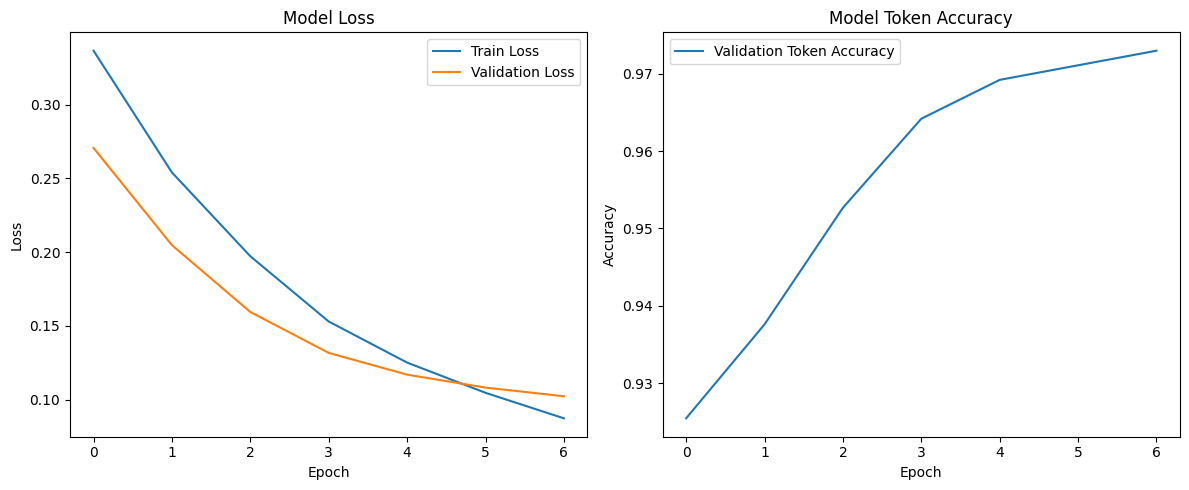

In [74]:
print("\n--- Plotting History ---")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies_token, label='Validation Token Accuracy')
plt.title('Model Token Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## 10.Final Evaluation on Dev Set

In [76]:
model.eval()
all_preds_final = []
all_true_final = []
with torch.no_grad():
    for features, labels in dev_loader:
        features = features.to(device)
        labels = labels.to(device)
        outputs = model(features)
        predictions = torch.argmax(outputs, dim=2).cpu().numpy()
        true_labels = labels.cpu().numpy()

        for i in range(features.shape[0]):
            seq_mask = true_labels[i] != pad_tag_idx
            pred_tags = [idx_to_tag[idx] for idx in predictions[i][seq_mask]]
            true_tags = [idx_to_tag[idx] for idx in true_labels[i][seq_mask]]
            all_preds_final.append(pred_tags)
            all_true_final.append(true_tags)


print("\nClassification Report (Chunk Level):")
print(seqeval_classification_report(all_true_final, all_preds_final,))


--- Final Evaluation on Dev Set ---

Classification Report (Chunk Level):
              precision    recall  f1-score   support

         GPE       0.74      0.80      0.77        74
         LOC       0.00      0.00      0.00         3
         ORG       0.62      0.65      0.63        60
         PER       0.77      0.83      0.80       108
         VEH       0.00      0.00      0.00         1

   micro avg       0.72      0.76      0.74       246
   macro avg       0.43      0.46      0.44       246
weighted avg       0.71      0.76      0.74       246



## 11. Test on Custom Sentence




In [78]:
print("\n--- Testing on Custom Sentence ---")
sentence = "Rick 's son got bitten by a zombie in Virginia . His name is Carl Grimes ."
print(f"Input: {sentence}")

# Preprocess
words = sentence.lower().split(' ')
indexed_sentence = [word_to_idx.get(w, word_to_idx["<UNK>"]) for w in words]

# Pad (needs padding to max_len if your model expects fixed input)
# Or adjust model/inference to handle variable length if needed.
# Here we pad to max_len for simplicity to match training data format.
padded_indexed_sentence = indexed_sentence + [pad_token_idx] * (max_len - len(indexed_sentence))
if len(padded_indexed_sentence) > max_len: # Truncate if longer
    padded_indexed_sentence = padded_indexed_sentence[:max_len]

input_tensor = torch.tensor([padded_indexed_sentence], dtype=torch.long).to(device) # Add batch dim

# Predict
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    predictions = torch.argmax(output, dim=2).squeeze(0).cpu().numpy() # Remove batch dim

# Convert indices to tags and print (only up to original length)
predicted_tags = [idx_to_tag[idx] for idx in predictions[:len(words)]]
for word, tag in zip(words, predicted_tags):
    print(f"{word:<10} {tag}")


--- Testing on Custom Sentence ---
Input: Rick 's son got bitten by a zombie in Virginia . His name is Carl Grimes .
rick       B-PER
's         O
son        O
got        O
bitten     O
by         O
a          O
zombie     O
in         O
virginia   O
.          O
his        O
name       O
is         O
carl       B-PER
grimes     I-PER
.          O
